In [ ]:
# Core RFM + Churn Analysis

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import squarify
import seaborn as sns

In [2]:
from sklearn.metrics import silhouette_score

In [3]:
# Merged Dataframe

In [4]:
df = pd.read_csv('dataframe.csv')

In [5]:
# Drop rows where direction = -1
df = df[df['direction'] != -1].copy()

In [7]:
df.drop('Unnamed: 0',axis = 1, inplace = True)

In [9]:
df.head()

,address_id,postal_code,district,region,customer_id,birthdate,gender,job_type,email_provider,flag_phone_provided,...,loyatlty_status,activation_date,order_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime,product_class
0,6962,29121,PC,EMILIA ROMAGNA,7821,1984-10-03,M,0,gmail.com,1.0,...,1,2022-04-06,cff01b663e65a4a426add3d3591dd113,11,33700716,1,0.2,0.00,2022-08-23 13:13:03,10
1,228406,24022,BG,LOMBARDIA,246969,1978-12-27,F,0,personal_mail_provider_7382,1.0,...,1,2022-03-13,8f7735a267cccb1e922a38d31b8f4b0b,40,33700716,1,0.2,0.00,2022-07-21 11:50:07,10
2,278496,125,RM,LAZIO,298715,1977-04-29,F,0,gmail.com,0.0,...,1,2022-04-08,8025322b509df76b6684eca2d262fde7,39,33700716,1,0.2,0.02,2022-06-03 09:22:35,10
3,278496,125,RM,LAZIO,298715,1977-04-29,F,0,gmail.com,0.0,...,1,2022-04-08,61b4e60e8f1503508a0f739e43b49df1,39,33700716,1,0.2,0.00,2023-03-28 12:30:35,10
4,385332,6059,PG,UMBRIA,406505,1976-04-26,F,0,gmail.com,1.0,...,1,2022-06-02,de7f5649c28e00f03cace55339474a35,9,33700716,1,0.2,0.00,2022-08-04 18:25:49,10


In [11]:
df.shape

(427, 25)

In [ ]:
# Active and Inactive Customers For past 90 days

In [12]:
import datetime

# Set the cutoff date as the current date minus 90 days
cutoff_date = datetime.datetime.now() - datetime.timedelta(days=90)
# Convert the 'purchase_datetime' column to datetime type
df['purchase_datetime'] = pd.to_datetime(df['purchase_datetime'])

# Calculate Recency, which represents the number of days since the customer's last purchase
recency_data = df.groupby('customer_id')['purchase_datetime'].max().reset_index()
recency_data['recency'] = (cutoff_date - recency_data['purchase_datetime']).dt.days
recency_data.drop('purchase_datetime', axis=1, inplace=True)

In [13]:
# Categorize customers as active or inactive based on the threshold
recency_data['status'] = recency_data['recency'].apply(lambda x: 'Active' if x <= 90 else 'Inactive')


In [15]:
recency_data.head()

,customer_id,recency,status
0,658,268,Inactive
1,2344,3,Active
2,7821,235,Inactive
3,20211,-4,Active
4,34088,23,Active


In [18]:
recency_data.shape

(57, 3)

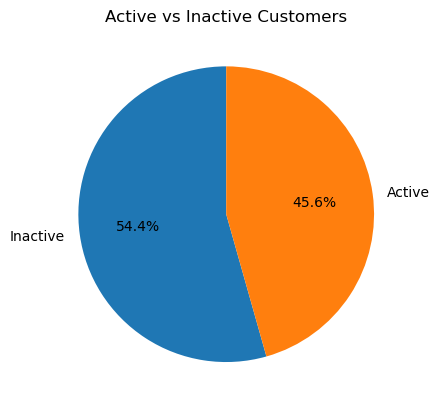

In [19]:
# Count the number of active and inactive customers
status_counts = recency_data['status'].value_counts()

# Create a pie plot
plt.pie(status_counts, labels=status_counts.index, autopct='%1.1f%%', startangle=90)

# Add a title
plt.title('Active vs Inactive Customers')

# Display the plot
plt.show()

In [20]:
import datetime

# Set the cutoff date as the current date minus 90 days
cutoff_date = datetime.datetime.now() - datetime.timedelta(days=90)

In [21]:
# Convert the 'purchase_datetime' column to datetime type
df['purchase_datetime'] = pd.to_datetime(df['purchase_datetime'])

# Calculate Recency, which represents the number of days since the customer's last purchase
recency_data = df.groupby('customer_id')['purchase_datetime'].max().reset_index()
recency_data['recency'] = (cutoff_date - recency_data['purchase_datetime']).dt.days
recency_data.drop('purchase_datetime', axis=1, inplace=True)

# Calculate Frequency, which represents the total number of purchases made by each customer
frequency_data = df.groupby('customer_id')['purchase_datetime'].count().reset_index()
frequency_data.rename(columns={'purchase_datetime': 'frequency'}, inplace=True)

# Calculate Monetary, which represents the total spending of each customer
monetary_data = df.groupby('customer_id')['gross_price'].sum().reset_index()
monetary_data.rename(columns={'gross_price': 'monetary'}, inplace=True)

# Merge the Recency, Frequency, and Monetary data
rfm_data = pd.merge(recency_data, frequency_data, on='customer_id')
rfm_data = pd.merge(rfm_data, monetary_data, on='customer_id')

# Assign scores or ranks to each RFM value
rfm_data['recency_score'] = pd.qcut(rfm_data['recency'], q=5, labels=False)
rfm_data['frequency_score'] = pd.qcut(rfm_data['frequency'], q=5, labels=False, duplicates='drop')
rfm_data['monetary_score'] = pd.qcut(rfm_data['monetary'], q=5, labels=False)

# Calculate the RFM score by combining the individual scores
rfm_data['rfm_score'] = rfm_data['recency_score'] + rfm_data['frequency_score'] + rfm_data['monetary_score']


In [22]:
rfm_data.head()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score
0,658,268,1,5.49,4,0,0,4
1,2344,3,34,347.33,0,4,4,8
2,7821,235,4,18.90,4,2,1,7
3,20211,-4,6,13.69,0,3,1,4
4,34088,23,18,77.00,1,4,3,8


In [23]:
# Define rfm_level function
def rfm_level(rfm_data):
    if rfm_data['rfm_score'] >= 9:
        return 'Can\'t Loose Them'
    elif ((rfm_data['rfm_score'] >= 8) and (rfm_data['rfm_score'] < 9)):
        return 'Champions'
    elif ((rfm_data['rfm_score'] >= 7) and (rfm_data['rfm_score'] < 8)):
        return 'Loyal'
    elif ((rfm_data['rfm_score'] >= 6) and (rfm_data['rfm_score'] < 7)):
        return 'Potential'
    elif ((rfm_data['rfm_score'] >= 5) and (rfm_data['rfm_score'] < 6)):
        return 'Promising'
    elif ((rfm_data['rfm_score'] >= 4) and (rfm_data['rfm_score'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm_data['RFM_Level'] = rfm_data.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm_data.head()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score,RFM_Level
0,658,268,1,5.49,4,0,0,4,Needs Attention
1,2344,3,34,347.33,0,4,4,8,Champions
2,7821,235,4,18.90,4,2,1,7,Loyal
3,20211,-4,6,13.69,0,3,1,4,Needs Attention
4,34088,23,18,77.00,1,4,3,8,Champions


In [24]:
rfm_data["RFM_Level"].value_counts()

Require Activation    12
Champions             10
Needs Attention        9
Can't Loose Them       9
Loyal                  7
Potential              6
Promising              4
Name: RFM_Level, dtype: int64

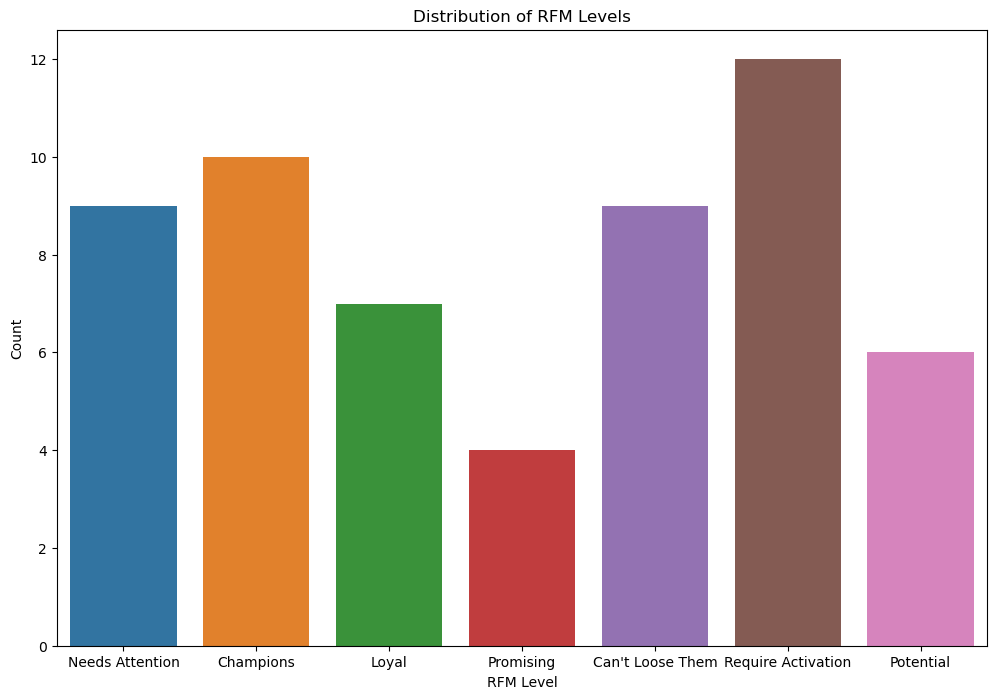

In [30]:
# Plot RFM levels
plt.figure(figsize=(12, 8))
sns.countplot(data=rfm_data, x='RFM_Level')
plt.xlabel('RFM Level')
plt.ylabel('Count')
plt.title('Distribution of RFM Levels')
plt.show()

In [481]:
# # Mean, median, count statistics of different segments
# rfm_data[["RFM_Level","recency","frequency", "monetary"]].groupby("RFM_Level").agg(["mean","median","count"])

In [482]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_df_agg = rfm_data.groupby('RFM_Level').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']}).round(1)
# Print the aggregated dataset
print(rfm_df_agg)

                   recency frequency monetary      
                      mean      mean     mean count
RFM_Level                                          
Can't Loose Them     154.4      16.4    519.7     9
Champions             98.5      14.8    538.5    10
Loyal                133.9       7.0     49.7     7
Needs Attention      153.4       2.8     17.0     9
Potential            149.2       3.3    142.2     6
Promising            104.8       3.0     39.5     4
Require Activation    70.1       2.1      9.7    12


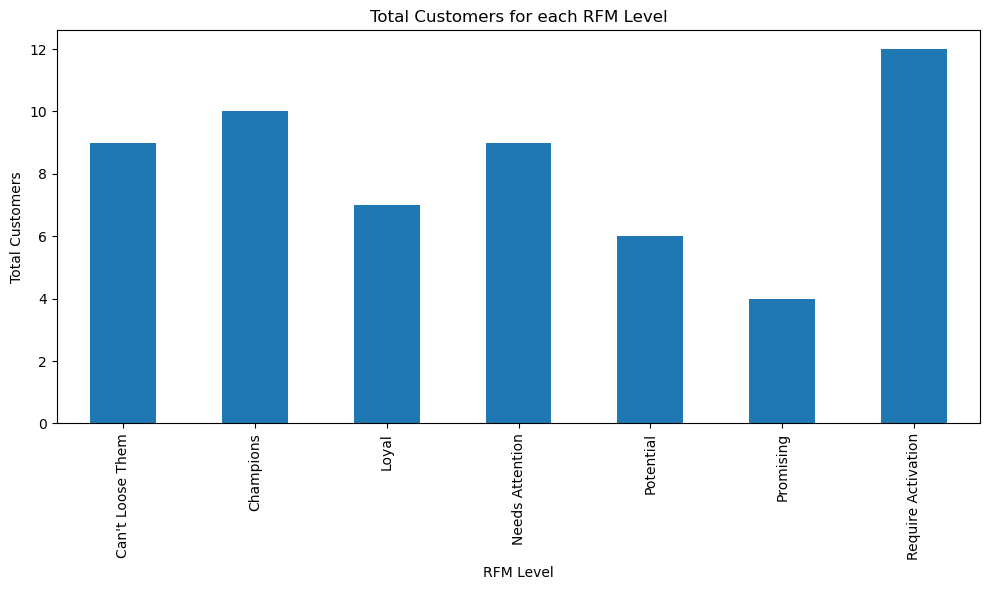

In [483]:
# Rename the columns for clarity
rfm_df_agg.columns = ['Avg. Recency', 'Avg. Frequency', 'Avg. Monetary', 'Total Customers']

# Plot the bar plot
rfm_df_agg['Total Customers'].plot(kind='bar', figsize=(10, 6))

# Customize the plot if needed
plt.xlabel('RFM Level')
plt.ylabel('Total Customers')
plt.title('Total Customers for each RFM Level')

# Display the plot
plt.tight_layout()
plt.show()

C:\Users\Admin\anaconda3\lib\site-packages\squarify\__init__.py:231: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



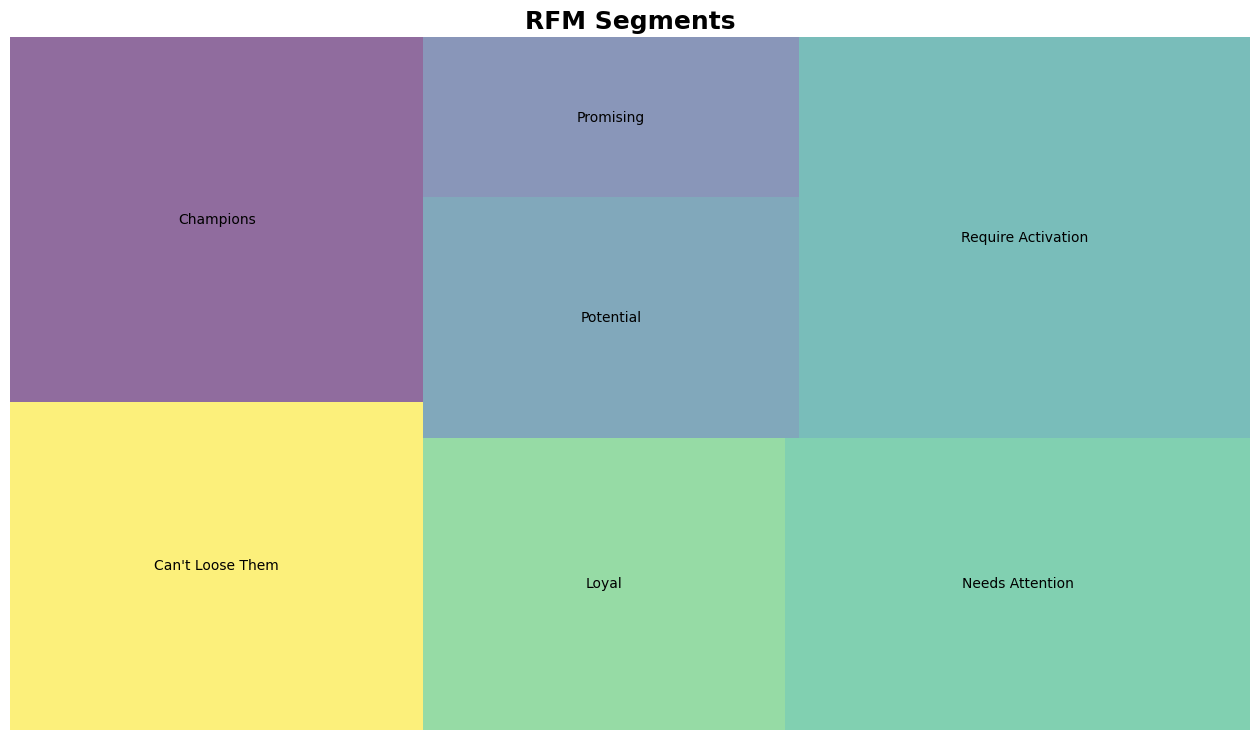

In [484]:
rfm_df_agg.columns = rfm_df_agg.columns
rfm_df_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_df_agg['Count'], 
              label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential',  #,
                     'Promising', 
                     'Require Activation'
                    ], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

In [ ]:
/////////////// K-means with elbow method ///////////////////////

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Adm

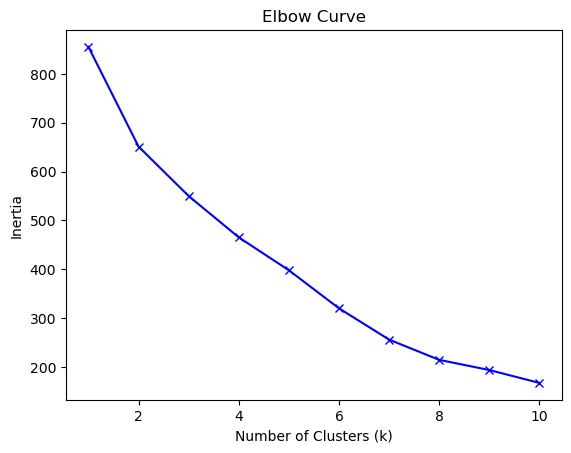

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

C:\Users\Admin\AppData\Local\Temp\ipykernel_19860\979204650.py:46: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [485]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

rfm_df_encoded = pd.get_dummies(rfm_data, columns=['RFM_Level'])

# Standardize the RFM data
scaler = StandardScaler()
rfm_data_scaled = scaler.fit_transform(rfm_df_encoded)


inertias = []
k_values = range(1, 11)  # Try different numbers of clusters
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(rfm_data_scaled)
    inertias.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()


optimal_k = 3  
kmeans = KMeans(n_clusters=optimal_k, random_state=0)
kmeans.fit(rfm_data_scaled)

# Assign the cluster labels to the original DataFrame
rfm_data['Cluster'] = kmeans.labels_

# Analyze the clusters
cluster_summary = rfm_data.groupby('Cluster').mean()



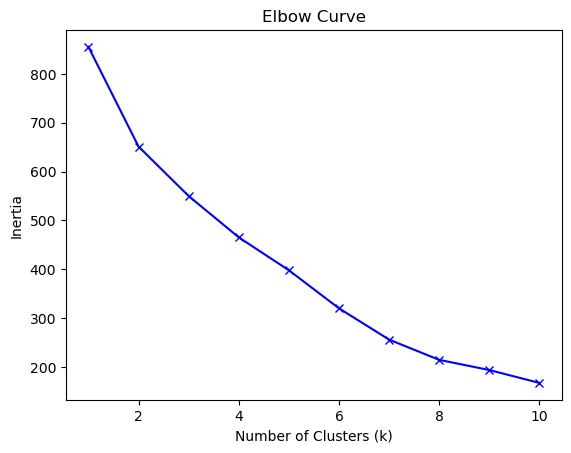

In [486]:
# Plot the elbow curve
plt.plot(k_values, inertias, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()

In [487]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(rfm_df_encoded)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [488]:
rfm_data.head()

,customer_id,recency,frequency,monetary,recency_score,frequency_score,monetary_score,rfm_score,RFM_Level,Cluster
0,658,266,1,5.49,4,0,0,4,Needs Attention,2
1,2344,1,34,347.33,0,4,4,8,Champions,0
2,7821,233,4,18.90,4,2,1,7,Loyal,1
3,20211,-6,6,13.69,0,3,1,4,Needs Attention,2
4,34088,21,18,77.00,1,4,3,8,Champions,0


In [489]:
rfm_data.shape

(57, 10)

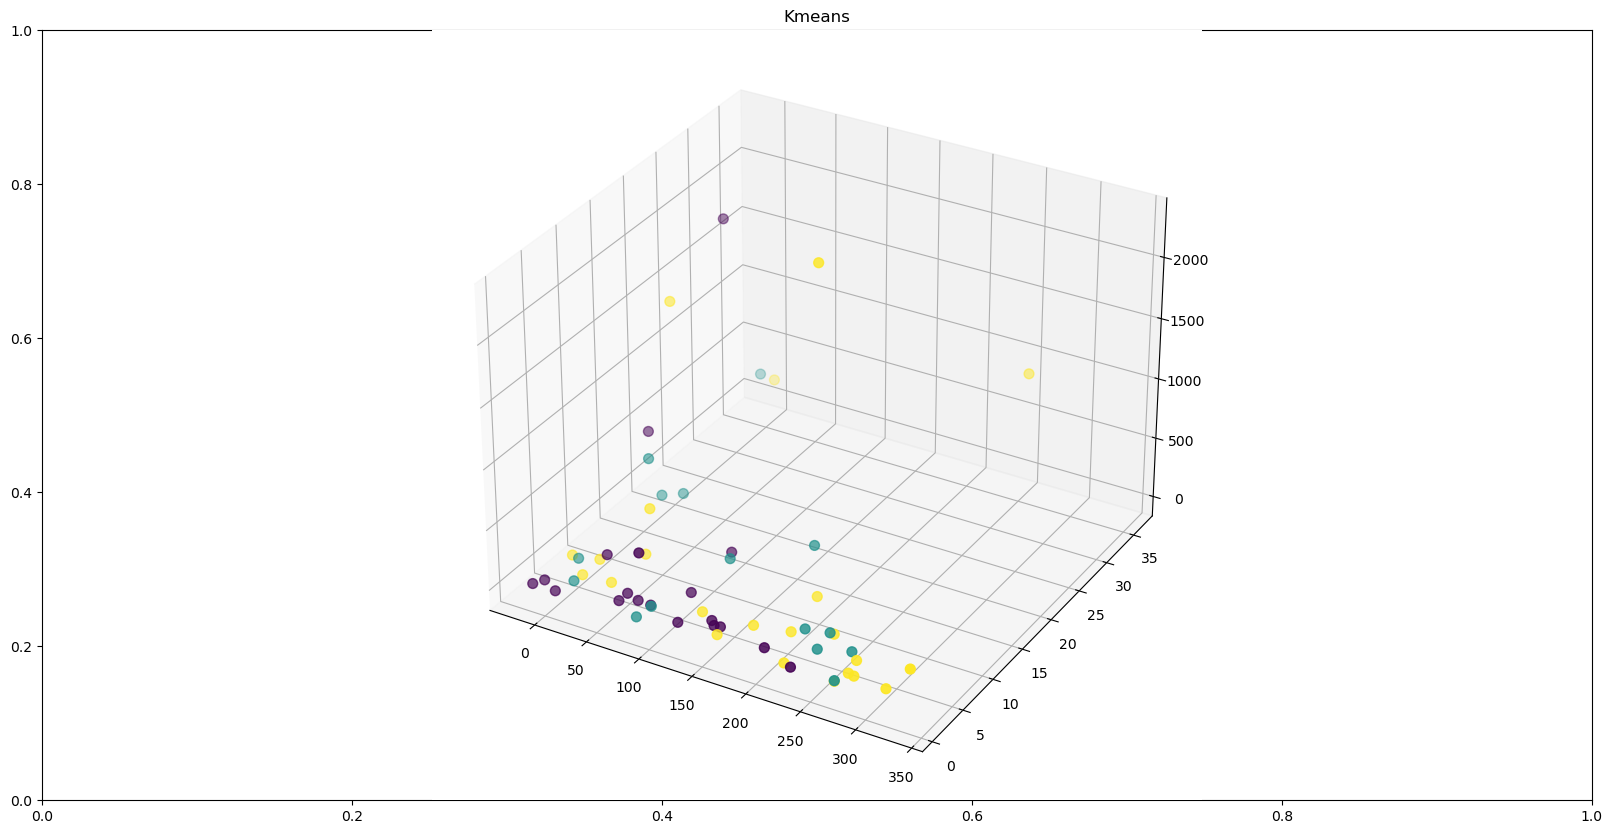

In [490]:
plt.figure(figsize = (20,10))
plt.title("Kmeans")
ax = plt.axes(projection='3d')
fg = ax.scatter3D(rfm_data['recency'],rfm_data['frequency'],rfm_data['monetary'],s = 50, c = y_kmeans,)

In [491]:
silhouette_avg = silhouette_score(rfm_df_encoded,y_kmeans)
print("For n_clusters =", 3 ,"The average silhouette_score is :",silhouette_avg)


For n_clusters = 3 The average silhouette_score is : 0.5988554432976071


In [ ]:
////////////////////////////////////using k-means with pca to plot in 2 d/////////////////////////////////////

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



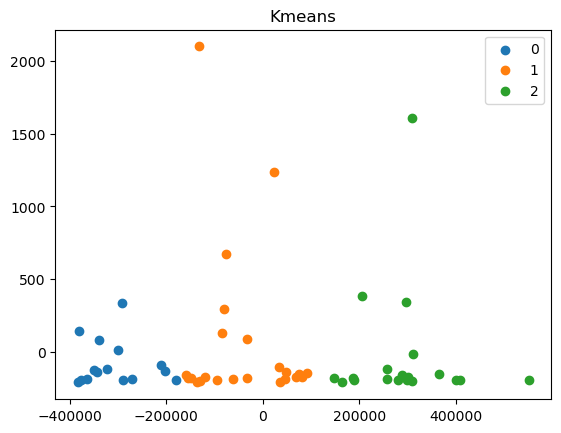

In [492]:
#Importing required modules
 
from sklearn.decomposition import PCA
import numpy as np
 
pca = PCA(2)
 
#Transform the data
df = pca.fit_transform(rfm_df_encoded)
 
#Import KMeans module
from sklearn.cluster import KMeans
 
#Initialize the class object
kmeans = KMeans(n_clusters= 3)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df)
 
#Getting unique labels
u_labels = np.unique(label)
 
#plotting the results:
for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.title("Kmeans")
plt.show()

In [493]:
# for the 2d data
silhouette_avg = silhouette_score(df,label)
print("For n_clusters =", 3 ,"The average silhouette_score is :",silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.5988566664296017


In [ ]:
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [ ]:
# Core 01 Customer Focus: prevention of the churn of high value customers by a marketing 
# campaign for customer retention [CHURN + RFM];

In [ ]:
# Calculate the monetary value for each customer by aggregating their total spending (gross_price) over a given period:

In [502]:
import pandas as pd

# Aggregate the total spending per customer
customer_monetary_value = df.groupby('customer_id')['gross_price'].sum()

# Convert the result into a DataFrame
customer_monetary_value = pd.DataFrame(customer_monetary_value)
customer_monetary_value.reset_index(inplace=True)  # Reset index for further processing

# Rename the column to reflect the monetary value
customer_monetary_value.rename(columns={'gross_price': 'monetary_value'}, inplace=True)


In [495]:
# Sort the customers based on their monetary value:

In [503]:
# Sort the customers based on their monetary value in descending order
customer_monetary_value.sort_values('monetary_value', ascending=False, inplace=True)

In [504]:
customer_monetary_value.head()

,customer_id,monetary_value
19,251068,2309.65
51,693062,1809.68
29,406505,1438.51
25,308545,885.91
42,589892,582.50


In [505]:
customer_monetary_value.shape

(57, 2)

In [506]:
# Select the top percentage of customers as high-value customers:

In [507]:
# Determine the number of customers to select as high-value customers (e.g., top 20%)
top_percentage = 0.24 # 24%
num_high_value_customers = int(len(customer_monetary_value) * top_percentage)

# Select the top percentage of customers as high-value customers
high_value_customers = customer_monetary_value.head(num_high_value_customers)

In [508]:
high_value_customers

,customer_id,monetary_value
19,251068,2309.65
51,693062,1809.68
29,406505,1438.51
25,308545,885.91
42,589892,582.50
47,680604,549.50
9,93263,536.13
24,304480,494.31
1,2344,347.33
23,298715,330.95


In [509]:
# Perform churn analysis and determine the churn status of each high-value customer

In [510]:
# Define the time period for churn analysis, such as the last 365 days. Set the cutoff date for the analysis.

In [511]:
import datetime

# Set the cutoff date as the current date minus 365 days
cutoff_date = datetime.datetime.now() - datetime.timedelta(days=365)

# Convert the cutoff date to datetime64[ns] type
cutoff_date = pd.to_datetime(cutoff_date)

# Filter the purchase data of high-value customers within the churn analysis period
# high_value_customer_ids = high_value_customers['customer_id'].tolist()
churn_analysis_data = df[df['customer_id'] & (pd.to_datetime(df['purchase_datetime']) >= cutoff_date)]


In [512]:
churn_analysis_data.head()

,address_id,postal_code,district,region,customer_id,birthdate,gender,job_type,email_provider,flag_phone_provided,...,loyatlty_status,activation_date,order_id,store_id,product_id,direction,gross_price,price_reduction,purchase_datetime,product_class
0,6962,29121,PC,EMILIA ROMAGNA,7821,1984-10-03,M,0,gmail.com,1.0,...,1,2022-04-06,cff01b663e65a4a426add3d3591dd113,11,33700716,1,0.2,0.0,2022-08-23 13:13:03,10
1,228406,24022,BG,LOMBARDIA,246969,1978-12-27,F,0,personal_mail_provider_7382,1.0,...,1,2022-03-13,8f7735a267cccb1e922a38d31b8f4b0b,40,33700716,1,0.2,0.0,2022-07-21 11:50:07,10
3,278496,125,RM,LAZIO,298715,1977-04-29,F,0,gmail.com,0.0,...,1,2022-04-08,61b4e60e8f1503508a0f739e43b49df1,39,33700716,1,0.2,0.0,2023-03-28 12:30:35,10
4,385332,6059,PG,UMBRIA,406505,1976-04-26,F,0,gmail.com,1.0,...,1,2022-06-02,de7f5649c28e00f03cace55339474a35,9,33700716,1,0.2,0.0,2022-08-04 18:25:49,10
11,625158,148,RM,LAZIO,640999,1974-07-11,F,0,hotmail.it,1.0,...,1,2022-11-08,ab5a674b6e9939cd62be6e12cbeb3386,33,33700716,1,0.2,0.0,2022-11-08 18:58:01,10


In [513]:
churn_analysis_data.shape

(142, 25)

In [514]:
COUNT  = churn_analysis_data['customer_id'].nunique()
COUNT

30

In [515]:
# Group the churn analysis data by customer and count the number of purchases
customer_purchases = churn_analysis_data.groupby('customer_id')['purchase_datetime'].count()

# Identify churned customers who have no purchases within the churn analysis period
churned_customers = customer_purchases[customer_purchases < 12].index.tolist()

In [516]:
customer_purchases

customer_id
7821       4
20211      6
40587      2
84587      9
93263     12
94505      1
181555    17
203601     2
225861     4
229985     1
234763     1
246969     1
264555     4
289021     1
298715     4
308545    16
352089     2
406505     9
431885     6
458071     6
531249     2
548505     1
640999    12
664885     1
672955     3
684219     2
696001     5
749375     3
785061     3
792819     2
Name: purchase_datetime, dtype: int64

In [517]:
churned_customers

[7821,
 20211,
 40587,
 84587,
 94505,
 203601,
 225861,
 229985,
 234763,
 246969,
 264555,
 289021,
 298715,
 352089,
 406505,
 431885,
 458071,
 531249,
 548505,
 664885,
 672955,
 684219,
 696001,
 749375,
 785061,
 792819]

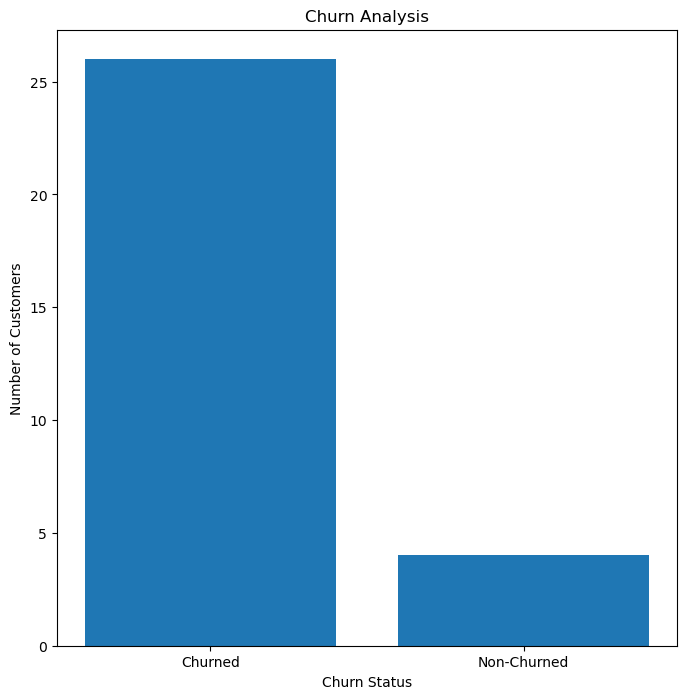

In [518]:

# Count the number of churned customers
num_churned = len(churned_customers)

# Plot the number of churned customers
plt.figure(figsize=(8, 8))
plt.bar(['Churned', 'Non-Churned'], [num_churned, len(customer_purchases) - num_churned])
plt.xlabel('Churn Status')
plt.ylabel('Number of Customers')
plt.title('Churn Analysis')
plt.show()


In [519]:
notChurned = len(customer_purchases) - num_churned
notChurned

4

In [520]:
rfm_data['Churn'] = 0
rfm_data.loc[(rfm_data['recency'] <= recency_threshold) & (rfm_data['frequency'] >= frequency_threshold) & (rfm_data['monetary'] >= monetary_threshold), 'Churn'] = 1


In [521]:
dfChurn = pd.merge(df, rfm_data, on='customer_id')
# Select the relevant attributes for churn prediction
dfChurn = dfChurn[['customer_id','recency', 'activation_date', 'loyatlty_status', 'Churn']]

In [522]:
dfChurn.drop_duplicates().head()

,customer_id,recency,activation_date,loyatlty_status,Churn
0,7821,233,2022-04-06,1,0
4,246969,266,2022-03-13,1,0
5,298715,15,2022-04-08,1,1
39,406505,-14,2022-06-02,1,1
61,693062,-10,2022-12-06,1,1


In [542]:
# Make churn probability predictions using the trained model
X_pred = dfChurn[['Recency', 'loyatlty_status']]
dfChurn['churn_probability'] = model.predict_proba(X_pred)[:, 1]


In [544]:
dfChurn.drop_duplicates().head()

,Recency,loyatlty_status,Churn,churn_probability
0,4,1,0,0.197716
4,1,1,0,0.156514
5,34,1,1,0.807997
39,22,1,1,0.574926
61,30,1,1,0.742440


In [523]:
# Applying Machine Learning Algorithms for churn prediction, such as Logistic Regression, 
# Random Forest, Multilayer Perceptrons, Decision Tree or Gradient Boosting Machine. 
# Fit the selected model to the training data.

In [524]:
from sklearn.model_selection import train_test_split

X = dfChurn[['customer_id', 'recency', 'activation_date', 'loyatlty_status']]
y = dfChurn['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [525]:
X_train

,customer_id,recency,activation_date,loyatlty_status
66,693062,-10,2022-12-06,1
132,458071,237,2022-07-02,1
223,572518,143,2022-09-21,1
31,298715,15,2022-04-08,1
84,693062,-10,2022-12-06,1
...,...,...,...,...
71,693062,-10,2022-12-06,1
106,640999,105,2022-11-08,1
270,474890,198,2022-07-14,1
348,45132,178,2022-04-15,1


In [526]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [527]:
# Convert 'purchase_datetime' column to datetime format
df['purchase_datetime'] = pd.to_datetime(df['purchase_datetime'])

# Merge the relevant attributes from dfOrders and dfCusAcc DataFrames based on the common column(s)
dfChurn = pd.merge(df, rfm_data, on='customer_id')

# Select the necessary features for churn prediction
dfChurn = dfChurn[['customer_id', 'purchase_datetime', 'loyatlty_status', 'Churn']]

# Calculate purchase frequency for each customer
dfChurn['Recency'] = dfChurn.groupby('customer_id')['purchase_datetime'].transform('count')

# Select the final features for churn prediction
dfChurn = dfChurn[['Recency', 'loyatlty_status', 'Churn']]

# Split the data into training and testing sets
X = dfChurn[['Recency', 'loyatlty_status']]
y = dfChurn['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a logistic regression model
model = LogisticRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.7790697674418605
Precision: 0.775
Recall: 0.7560975609756098
F1-score: 0.7654320987654322


In [286]:
### Random Forest Classifier

In [528]:

from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, random_state=42)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)


In [529]:
#Returns the mean accuracy on the given test data and labels.
print("Accuracy:", f"{round(rf_clf.score(X_test, y_test), 4):.2%}")

Accuracy: 93.02%


In [530]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.9302325581395349
Precision: 0.8723404255319149
Recall: 1.0
F1-score: 0.9318181818181819


In [ ]:
### Multilayer Perceptron

In [531]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

mlp_clf = MLPClassifier()  # Instantiate an instance of the MLPClassifier
mlp_clf.fit(X_train, y_train)  # Fit the model to the training data

y_pred = mlp_clf.predict(X_test)  # Make predictions on the test data

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.813953488372093
Precision: 0.7192982456140351
Recall: 1.0
F1-score: 0.8367346938775511


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.



In [ ]:
###  Gradient Boosting Machine

In [532]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Create a Gradient Boosting Classifier
gbm_clf = GradientBoostingClassifier() 

# Fit the model to the training data
gbm_clf.fit(X_train, y_train)  

# Make predictions on the test data
y_pred = gbm_clf.predict(X_test)  

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.9302325581395349
Precision: 0.8723404255319149
Recall: 1.0
F1-score: 0.9318181818181819


In [ ]:
# Decision Tree

In [534]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
 
# Create a Decision Tree classifier
dct_clf = DecisionTreeClassifier()

# Fit the model to the training data
dct_clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dct_clf.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.9302325581395349
Precision: 1.0
Recall: 0.8536585365853658
F1-score: 0.9210526315789475


In [ ]:
### ROC curve and AUC

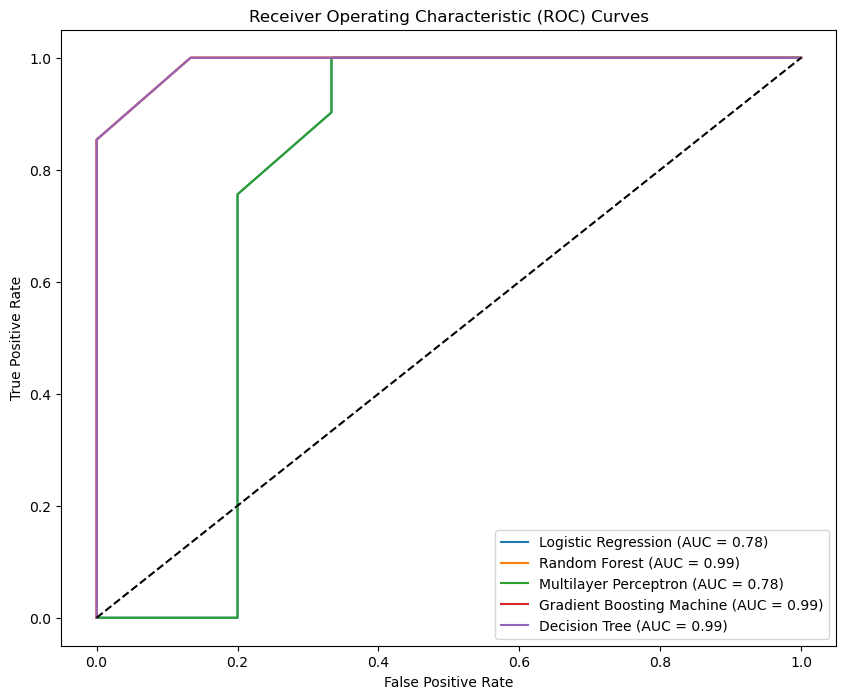

In [535]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

classifiers = {
    "Logistic Regression": model,
    "Random Forest": rf_clf,
    "Multilayer Perceptron": mlp_clf,
    "Gradient Boosting Machine": gbm_clf,
    "Decision Tree" : dct_clf
}

plt.figure(figsize=(10, 8))

# Plot ROC curve for each classifier
for name, clf in classifiers.items():
    y_pred_probs = clf.predict_proba(X_test)[:, 1] 
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='%s (AUC = %0.2f)' % (name, roc_auc))

# Plot the random guessing line
plt.plot([0, 1], [0, 1], 'k--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.show()


In [ ]:
////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////